In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("IP address of the router is 192.0.2.1 ")

for tok in doc:
  print(tok.text, "...", tok.dep_)

IP ... compound
address ... nsubj
of ... prep
the ... det
router ... pobj
is ... ROOT
192.0.2.1 ... attr


In [2]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [3]:

import pandas as pd
import nltk
nltk.download('punkt')

text = "The Ruckus R550 is a powerful and feature-packed Wi-Fi 6 router that is designed for indoor use in homes, small offices, and medium-sized enterprises. This router is an excellent choice for those who demand high-performance, reliable, and secure Wi-Fi connectivity for their business or personal use. One of the most notable features of the Ruckus R550 is its support for the latest Wi-Fi 6 (802.11ax) standard. This new standard offers improved speeds, better range, and increased capacity compared to previous Wi-Fi standards. With Wi-Fi 6, you can experience faster downloads, smoother streaming, and better overall performance, especially in environments with many connected devices. The R550 offers dual-band connectivity, with support for both the 2.4 GHz and 5 GHz bands. This allows you to take advantage of the full capabilities of Wi-Fi 6, as well as support legacy devices that only support older Wi-Fi standards. The router also features advanced adaptive antenna technology, which enables it to automatically adjust its antennas to optimize signal strength and quality. Another important feature of the R550 is its support for MU-MIMO (Multi-User Multiple Input Multiple Output) technology. This allows the router to communicate with multiple devices simultaneously, which can improve overall network performance and reduce latency. MU-MIMO is particularly useful in environments with many connected devices, as it enables the router to handle multiple connections more efficiently. The R550 also supports SmartMesh wireless mesh networking technology, which allows you to extend your Wi-Fi coverage by creating a mesh network with multiple access points. This is ideal for larger homes or offices where a single router may not provide adequate coverage. In terms of security, the R550 supports a range of advanced features to help protect your network from unauthorized access and attacks. These include WPA2-PSK, WPA2-Enterprise, MAC address filtering, VLAN support, and HTTPS login. The router also supports cloud management through Ruckus Cloud or on-premises management with ZoneDirector or SmartZone controllers, giving you complete control over your network and its security. Overall, the Ruckus R550 is an excellent choice for anyone looking for a high-performance Wi-Fi 6 router. Its advanced features, including MU-MIMO, adaptive antenna technology, and SmartMesh support, make it ideal for homes and businesses with many connected devices. And with its robust security features and cloud management capabilities, you can be sure that your network is safe and secure."
sentences = nltk.sent_tokenize(text)
df = pd.DataFrame(columns=['Sentences'])
rows_list = []

for sentence in sentences:
    rows_list.append({'Sentences': sentence})
df = pd.DataFrame(rows_list)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [5]:

# import wikipedia sentences
candidate_sentences = df
candidate_sentences.shape

(19, 1)

In [6]:
candidate_sentences.head()

,Sentences
0,"The Ruckus R550 is a powerful and feature-packed Wi-Fi 6 router that is designed for indoor use in homes, small offices, and medium-sized enterprises."
1,"This router is an excellent choice for those who demand high-performance, reliable, and secure Wi-Fi connectivity for their business or personal use."
2,One of the most notable features of the Ruckus R550 is its support for the latest Wi-Fi 6 (802.11ax) standard.
3,"This new standard offers improved speeds, better range, and increased capacity compared to previous Wi-Fi standards."
4,"With Wi-Fi 6, you can experience faster downloads, smoother streaming, and better overall performance, especially in environments with many connected devices."


In [7]:
candidate_sentences['Sentences']

0                                                   The Ruckus R550 is a powerful and feature-packed Wi-Fi 6 router that is designed for indoor use in homes, small offices, and medium-sized enterprises.
1                                                    This router is an excellent choice for those who demand high-performance, reliable, and secure Wi-Fi connectivity for their business or personal use.
2                                                                                           One of the most notable features of the Ruckus R550 is its support for the latest Wi-Fi 6 (802.11ax) standard.
3                                                                                     This new standard offers improved speeds, better range, and increased capacity compared to previous Wi-Fi standards.
4                                           With Wi-Fi 6, you can experience faster downloads, smoother streaming, and better overall performance, especially in environments with many conn

In [8]:
#check the subject and object of one of these sentences. 
#Ideally, there should be one subject and one object in the sentence:
doc = nlp("The Ruckus R550 is a powerful and feature-packed Wi-Fi 6 router that is designed for indoor use in homes, small offices, and medium-sized enterprises.")
for tok in doc:
  print(tok.text, "...", tok.dep_)
#There is only one subject (‘process’) and only one object (‘standard’)

The ... det
Ruckus ... compound
R550 ... nsubj
is ... ROOT
a ... det
powerful ... amod
and ... cc
feature ... npadvmod
- ... punct
packed ... conj
Wi ... nmod
- ... punct
Fi ... nmod
6 ... nummod
router ... attr
that ... nsubjpass
is ... auxpass
designed ... relcl
for ... prep
indoor ... amod
use ... pobj
in ... prep
homes ... pobj
, ... punct
small ... amod
offices ... conj
, ... punct
and ... cc
medium ... amod
- ... punct
sized ... amod
enterprises ... conj
. ... punct


In [9]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [10]:
get_entities("MU-MIMO is particularly useful in environments with many connected devices, as it enables the router to handle multiple connections more efficiently.")


['router', 'multiple  connections']

In [11]:
entity_pairs = []

for i in tqdm(candidate_sentences["Sentences"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 19/19 [00:00<00:00, 69.96it/s]


In [12]:
entity_pairs[0:20]

[['6  that', 'indoor  homes'],
 ['excellent  who', 'high Wi Fi business'],
 ['One', '802.11ax Wi standard'],
 ['new  standard', 'previous Wi Fi standards'],
 ['6 Wi you', 'connected  devices'],
 ['R550', '2.4 band GHz'],
 ['well support legacy that', 'Wi Fi standards'],
 ['adaptive antenna which', 'automatically signal strength'],
 ['important  feature', 'Multiple Output Input Multiple technology'],
 ['simultaneously  which', 'overall network latency'],
 ['router', 'multiple  connections'],
 ['you', 'multiple access points'],
 ['single  router', 'adequate  coverage'],
 ['R550', 'unauthorized  access'],
 ['These', 'WPA2 PSK'],
 ['router', 'complete SmartZone network'],
 ['excellent  anyone', '6  router'],
 ['adaptive SmartMesh it', 'connected  devices'],
 ['network', 'robust security features']]

In [13]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]] 
  
  matcher.add("matching_1",pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [14]:
get_relation("MU-MIMO is particularly useful in environments with many connected devices, as it enables the router to handle multiple connections more efficiently.")

'is'

In [15]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Sentences'])]


100%|██████████| 19/19 [00:00<00:00, 73.72it/s]


In [16]:
for i in range(0,len(relations)):
  print(entity_pairs[i][0] + "------" + relations[i] + "------ " + entity_pairs[i][1])

6  that------is------ indoor  homes
excellent  who------is------ high Wi Fi business
One------is------ 802.11ax Wi standard
new  standard------offers------ previous Wi Fi standards
6 Wi you------experience faster------ connected  devices
R550------offers dual------ 2.4 band GHz
well support legacy that------allows------ Wi Fi standards
adaptive antenna which------features advanced------ automatically signal strength
important  feature------is------ Multiple Output Input Multiple technology
simultaneously  which------allows------ overall network latency
router------is------ multiple  connections
you------supports------ multiple access points
single  router------is ideal------ adequate  coverage
R550------supports------ unauthorized  access
These------include------ WPA2 PSK
router------supports------ complete SmartZone network
excellent  anyone------is------ 6  router
adaptive SmartMesh it------make------ connected  devices
network------be sure------ robust security features


In [17]:
pd.Series(relations).value_counts()[:50]

is                   6
supports             3
allows               2
offers               1
experience faster    1
offers dual          1
features advanced    1
is ideal             1
include              1
make                 1
be sure              1
dtype: int64

In [18]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [19]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

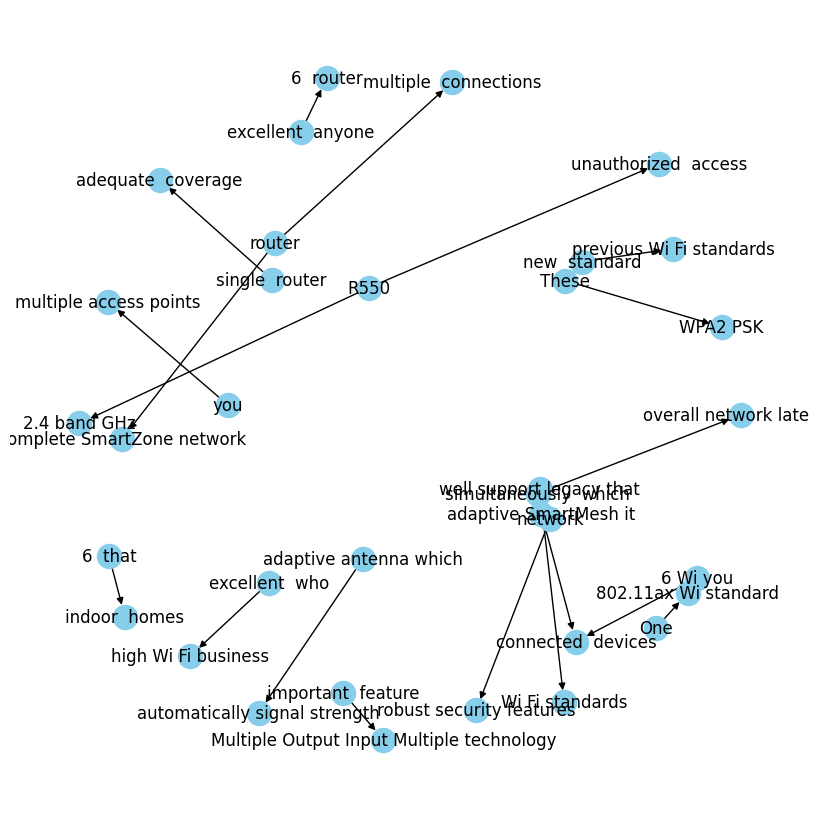

In [20]:
plt.figure(figsize=(8,8))

pos = nx.spring_layout(G,k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

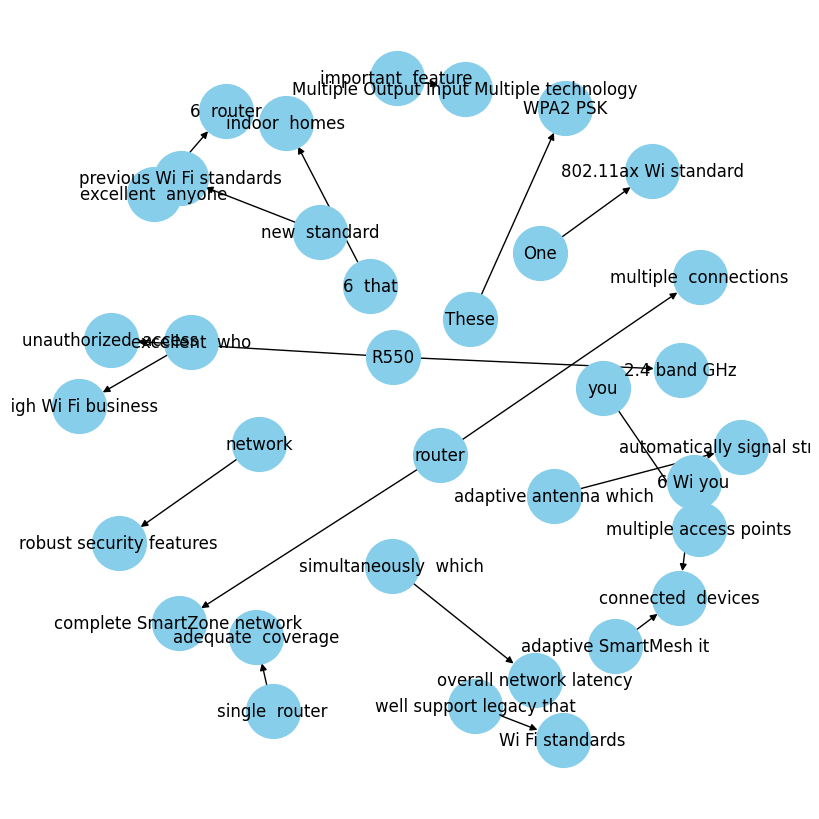

In [21]:


plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()